In [1]:
import pandas as pd  # data processing, CSV file I/O
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

# make a plot outputs appear and be stored within the notebook
%matplotlib inline

print("Complete")

Complete


In [2]:
LETTER_NAMES = {
    1: "alif",
    10: "ra",
    11: "zay",
    12: "sin",
    13: "shin",
    14: "sad",
    15: "dad",
    16: "da",
    17: "za",
    18: "ayn",
    19: "gayn",
    2: "ba",
    20: "fa",
    21: "qaf",
    22: "kaf",
    23: "lam",
    24: "mim",
    25: "non",
    26: "ha",
    27: "waw",
    28: "ya",
    29: "hamza",
    3: "ta",
    4: "tha",
    5: "gim",
    6: "ha",
    7: "kha",
    8: "dal",
    9: "thal"
}

In [3]:
x_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")

In [4]:
print(x_train.columns)
print(y_train.columns)
assert len(x_train) == len(y_train)

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel1014', 'pixel1015', 'pixel1016', 'pixel1017', 'pixel1018',
       'pixel1019', 'pixel1020', 'pixel1021', 'pixel1022', 'pixel1023'],
      dtype='object', length=1024)
Index(['label'], dtype='object')


In [5]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Columns: 1024 entries, pixel0 to pixel1023
dtypes: int64(1024)
memory usage: 296.4 MB


In [6]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   37933 non-null  int64
dtypes: int64(1)
memory usage: 296.5 KB


### Distributions

<AxesSubplot:>

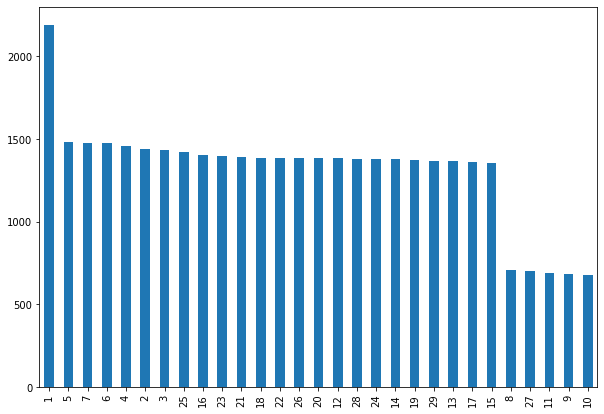

In [7]:
plt.figure(figsize=(10,7))
y_train['label'].value_counts().plot(kind="bar")

In [8]:
max([x_train[column].max() for column in x_train.columns] )

255

So each pixel takes value 0-255

### Changing data format to compatible with tf training

Shuffling

In [9]:
idx = np.random.permutation(x_train.index)
x_train = x_train.reindex(idx)
y_train = y_train.reindex(idx)

In [10]:
def convert_to_tensor(x_data):
    rows_num = len(x_data)
    new_shape = [rows_num, 32, 32, 1]
    print(new_shape)
    x_data_tf = x_data.values.reshape(new_shape)
    x_data_tf = tf.convert_to_tensor(x_data_tf)
    x_data_tf = x_data_tf / 255 # normalisation from 0 - 255 to 0 - 1
    return x_data_tf

In [11]:
x_train_tf = convert_to_tensor(x_train)
x_train_tf

[37933, 32, 32, 1]


<tf.Tensor: shape=(37933, 32, 32, 1), dtype=float64, numpy=
array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],




In [12]:
y_train_tf = y_train - 1
y_train_tf

,label
1879,0
1247,0
28655,21
37161,28
7069,4
...,...
33780,25
1475,0
19939,15
1337,0


### Test data
For assessing accuracy, loss, etc

In [13]:
x_test = pd.read_csv("./X_test.csv")
y_test = pd.read_csv("./y_test.csv")

In [14]:
x_test_tf = convert_to_tensor(x_test)
y_test_tf = y_test - 1
y_test_tf

[9501, 32, 32, 1]


,label
0,0
1,0
2,0
3,0
4,0
...,...
9496,28
9497,28
9498,28
9499,28


### TF model

In [46]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
NUMBER_OF_LAYERS = 7
NUMBER_OF_CONV2D = 5

In [47]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 1)))
    for i in range(NUMBER_OF_CONV2D):
        model.add(tf.keras.layers.Conv2D(16, 3, padding="same", activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int('units_0', min_value=5, max_value=2048//i, step=5)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(tf.keras.layers.Reshape((hp_units,1)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
    model.add(tf.keras.layers.Flatten())

    for i in range(1, NUMBER_OF_LAYERS + 1):
        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 5-1024
        hp_units = hp.Int(f'units_{i}', min_value=5, max_value=2048//i, step=5)
        model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Dense(29, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

    return model

In [48]:
tuner = kt.Hyperband(model_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    project_name='hyperparams')

In [49]:
tuner.search(x_train_tf, y_train_tf, epochs=50, validation_split=0.1, shuffle=True, callbacks=[stop_early])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
300               |?                 |units_0
425               |?                 |units_1
445               |?                 |units_2
315               |?                 |units_3
195               |?                 |units_4
200               |?                 |units_5
260               |?                 |units_6
115               |?                 |units_7
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
3                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2


KeyboardInterrupt: 

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
for i in range(NUMBER_OF_LAYERS + 1):
    print(f"Layer {i}: {best_hps.get(f'units_{i}')}")

Layer 1: 365
Layer 2: 305
Layer 3: 415
Layer 4: 300
Layer 5: 135
Layer 6: 40
Layer 7: 150


In [ ]:
history = model.fit(x_train_tf, y_train_tf, epochs=300, shuffle=True, validation_split=0.1, callbacks=[stop_early])

Epoch 1/300
1067/1067 [==============================] - 30s 24ms/step - loss: 3.2293 - accuracy: 0.0774 - val_loss: 2.9591 - val_accuracy: 0.1215
Epoch 2/300
1067/1067 [==============================] - 25s 24ms/step - loss: 2.7995 - accuracy: 0.1473 - val_loss: 2.7051 - val_accuracy: 0.1650
Epoch 3/300
1067/1067 [==============================] - 25s 24ms/step - loss: 2.4625 - accuracy: 0.2127 - val_loss: 2.1851 - val_accuracy: 0.2681
Epoch 4/300
1067/1067 [==============================] - 25s 23ms/step - loss: 2.0367 - accuracy: 0.3136 - val_loss: 1.7453 - val_accuracy: 0.3959
Epoch 5/300
1067/1067 [==============================] - 25s 24ms/step - loss: 1.7336 - accuracy: 0.4108 - val_loss: 1.6146 - val_accuracy: 0.4491
Epoch 6/300
1067/1067 [==============================] - 25s 24ms/step - loss: 1.5353 - accuracy: 0.4891 - val_loss: 1.4798 - val_accuracy: 0.5105
Epoch 7/300
1067/1067 [==============================] - 25s 24ms/step - loss: 1.3851 - accuracy: 0.5464 - val_loss: 1

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 16)        

In [ ]:
test_loss, test_acc = model.evaluate(x_test_tf,  y_test_tf, verbose=2)

print('\nTest accuracy:', test_acc)

297/297 - 2s - loss: 0.8041 - accuracy: 0.7789 - 2s/epoch - 7ms/step

Test accuracy: 0.778865396976471
